# Project 242

## Import

In [294]:
from backtester.backtesting import Strategy
from modules.data_preprocessing import *
from modules.add_features import *
from modules.metrics_prediction import *
from modules.metrics_performance import *
from modules.models import *
from modules.utils import *

In [295]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random as rd

## I. Data

### 1. Load data

In [296]:
data = pd.read_csv('data/Binance_BTCUSDT_1h.csv')

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USDT,tradecount
0,1.637280e+12,2021-11-19 00:00:00,BTC/USDT,56891.62,57247.58,56674.00,57144.98,719.65701,4.099574e+07,19977.0
1,1.637276e+12,2021-11-18 23:00:00,BTC/USDT,56613.30,56987.57,56474.26,56891.62,2553.36240,1.447890e+08,76763.0


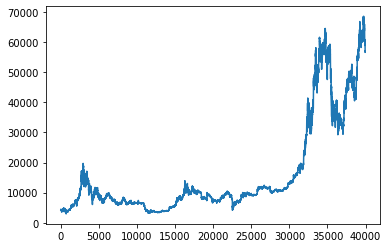

In [297]:
plt.plot(data[::-1].reset_index().close)
data.head(2)

### 2. Preprocess data

- clean data
- add features

In [298]:
# Clean data
data = clean_data(data)
data = data.rename(columns = {'Volume USDT': 'Volume'})
data.columns

Index(['open', 'high', 'low', 'close', 'Volume'], dtype='object')

Here, we can decide to add features ...

In [299]:
# Add features

data = add_technical_indicators(data, lookback_period=30)[30:]

In [300]:
data = data.drop(['VWAP'], axis = 1)

In [301]:
# Split data
train_data, test_data = split_data(data, split=0.25)

train_data = array_to_df(train_data, data.columns)
test_data = array_to_df(test_data, data.columns)

print(f'Shape X_train: {train_data.shape} | X_test: {test_data.shape}')

Shape X_train: (29936, 12) | X_test: (9978, 12)


In [302]:
# Scale data
#train_data, test_data = scale_data(train_data, test_data)

In [303]:
# Add Return
train_data = add_return(train_data)
test_data = add_return(test_data)

In [304]:
# Add Signal
q_75 = np.quantile(abs(train_data.Return).iloc[:-1].values, 0.75)

train_data = add_signal(train_data, q_75)
test_data = add_signal(test_data, q_75)

In [305]:
train_pos, train_neg = round((train_data.Signal>0).sum()/train_data.Signal.shape[0],2)*100, round((train_data.Signal<0).sum()/train_data.Signal.shape[0],2)*100
test_pos, test_neg = round((test_data.Signal>0).sum()/test_data.Signal.shape[0],2)*100, round((test_data.Signal<0).sum()/test_data.Signal.shape[0],2)*100

print(f'Train set: 1 ({train_pos}%) | 0 ({100-(train_pos+train_neg)}%) | -1 ({train_neg}%)') 
print(f'Test set: 1 ({test_pos}%) | 0 ({100-(test_pos+test_neg)}%) | -1 ({test_neg}%)') 

Train set: 1 (13.0%) | 0 (75.0%) | -1 (12.0%)
Test set: 1 (19.0%) | 0 (65.0%) | -1 (16.0%)


In [306]:
#display(train_data.head(2))
#display(test_data.head(2))

## II. Model

### 1. Get data ready for models

In this section, the reformating of the data may depend on the model ...

In [307]:
train = prepare_data_2D_format(train_data)
train.head()

/Users/noemielevy/INDENG-242-project/modules/data_preprocessing.py:59: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(X), S, R


,open_day_minus10,high_day_minus10,low_day_minus10,close_day_minus10,Volume_day_minus10,MOM_day_minus10,RSI_day_minus10,BB_high_day_minus10,BB_low_day_minus10,EMA_day_minus10,...,close_day_minus1,Volume_day_minus1,MOM_day_minus1,RSI_day_minus1,BB_high_day_minus1,BB_low_day_minus1,EMA_day_minus1,CCI_day_minus1,MACD_day_minus1,Signal
0,4304.15,4371.52,4296.04,4356.31,223471.00,-29.750833,53.271105,4462.289132,4215.078202,4318.454360,...,4136.28,243223.71,-95.738000,37.425276,4425.102035,4157.654632,4276.262939,-280.041820,-95.738000,-1
1,4236.89,4283.79,4234.54,4250.34,189710.83,-46.711333,44.300512,4439.145725,4200.294942,4304.723489,...,4148.53,120196.97,-147.241833,43.437795,4431.486566,4045.751434,4216.508106,-63.760707,-147.241833,-1
2,4193.35,4297.75,4117.41,4117.41,104309.76,-74.240667,35.592911,4436.143197,4168.128137,4285.916935,...,4138.55,71698.58,-77.413667,43.028852,4417.918492,4035.063508,4207.850195,-67.937282,-77.413667,-1
3,4136.28,4136.28,3981.13,4021.11,76391.96,-116.538500,31.726393,4426.152068,4126.623932,4259.801459,...,4077.00,47094.85,-74.949833,40.225841,4410.285172,4010.922161,4190.983448,-102.222502,-74.949833,-1
4,4077.00,4082.00,3986.87,3986.87,201920.41,-92.501000,36.313482,4413.638948,3987.591052,4177.814839,...,3972.05,32834.24,-103.921167,40.741816,4348.360954,3895.303046,4107.695434,-85.948662,-103.921167,-1


In [308]:
X_train, y_train, return_train = prepare_data_for_training(train_data, lookback_period=10, signal = True)
X_test, y_test, return_test = prepare_data_for_training(test_data, lookback_period=10, signal = True)

y_train = y_train[10:]

/Users/noemielevy/INDENG-242-project/modules/data_preprocessing.py:59: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(X), S, R


In [309]:
## Remove empty lists in the beginning
while len(X_train[0]) == 0:
    X_train = X_train[1:]
    y_train = y_train[1:]
    
while len(X_test[0]) == 0:
    X_test = X_test[1:]
    y_test = y_test[1:]

In [310]:
from tqdm import tqdm
def format_2D(arr):
    res = []
    for item in arr:
        features = []
        for day in item:
            features += day.tolist()
        res.append(features)
    return res
X_train = format_2D(X_train)
X_test = format_2D(X_test)

In [311]:
## Some indicators have a larger lookback period than other. 
## We remove the beginning of the dataset to make everything homogeneous

while len(X_train[0]) != 10*len(data.columns):
    X_train = X_train[1:]
    y_train = y_train[1:]
    
while len(X_test[0]) != 10*len(data.columns):
    X_test = X_test[1:]
    y_test = y_test[1:]
    
X_train = np.array(X_train)
X_test = np.array(X_test)

### 2. Build model

The ultimate goal of this section is to return a **prediction**.

This section may recquire a phase of **feature selection**.

...

In [312]:
features = []
for k in range(10):
    features = features + [col+"_day_minus"+str(10-k) for col in data.columns]

In [313]:
train = pd.DataFrame(X_train)
train.columns = features
train['Signal'] = pd.Series(y_train)

test = pd.DataFrame(X_test)
test.columns = features
test['Signal'] = pd.Series(y_test)

In [314]:
str_formula = 'Signal ~ '
for feat in features:
    str_formula += feat + ' + '
str_formula = str_formula[:-3]

In [315]:
import statsmodels.formula.api as smf
import numpy as np

# at first I will use all features
# fitting data to the model
reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.550
Date:                Fri, 03 Dec 2021   Prob (F-statistic):           0.000341
Time:                        13:56:56   Log-Likelihood:                -21591.
No. Observations:               29896   AIC:                         4.339e+04
Df Residuals:                   29794   BIC:                         4.423e+04
Df Model:                         101                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.0009    

We perform feature selection using the p-value

In [316]:
## remove high_day_minus4:
removed = ['high_day_minus4']
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.560
Date:                Fri, 03 Dec 2021   Prob (F-statistic):           0.000301
Time:                        13:56:59   Log-Likelihood:                -21591.
No. Observations:               29896   AIC:                         4.338e+04
Df Residuals:                   29795   BIC:                         4.422e+04
Df Model:                         100                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.0011    

In [317]:
## remove Volume_day_minus2:
removed = ['high_day_minus4', 'Volume_day_minus2']
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.568
Date:                Fri, 03 Dec 2021   Prob (F-statistic):           0.000272
Time:                        13:57:03   Log-Likelihood:                -21592.
No. Observations:               29896   AIC:                         4.338e+04
Df Residuals:                   29796   BIC:                         4.421e+04
Df Model:                          99                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.0013    

In [318]:
## remove Volume_day_minus8:
removed = ['high_day_minus4', 'Volume_day_minus2', 'Volume_day_minus8']
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.579
Date:                Fri, 03 Dec 2021   Prob (F-statistic):           0.000234
Time:                        13:57:06   Log-Likelihood:                -21592.
No. Observations:               29896   AIC:                         4.338e+04
Df Residuals:                   29797   BIC:                         4.420e+04
Df Model:                          98                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.0014    

In [319]:
## remove MOM_day_minus6:
removed.append('MOM_day_minus6')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.579
Date:                Fri, 03 Dec 2021   Prob (F-statistic):           0.000234
Time:                        13:57:08   Log-Likelihood:                -21592.
No. Observations:               29896   AIC:                         4.338e+04
Df Residuals:                   29797   BIC:                         4.420e+04
Df Model:                          98                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.0014    

In [320]:
## remove MACD_day_minus6:
removed.append('MACD_day_minus6')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.591
Date:                Fri, 03 Dec 2021   Prob (F-statistic):           0.000198
Time:                        13:57:11   Log-Likelihood:                -21592.
No. Observations:               29896   AIC:                         4.338e+04
Df Residuals:                   29798   BIC:                         4.419e+04
Df Model:                          97                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.0016    

In [321]:
## remove high_day_minus3:
removed.append('high_day_minus3')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.587
Date:                Fri, 03 Dec 2021   Prob (F-statistic):           0.000230
Time:                        13:57:14   Log-Likelihood:                -21593.
No. Observations:               29896   AIC:                         4.338e+04
Df Residuals:                   29799   BIC:                         4.419e+04
Df Model:                          96                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.0018    

In [322]:
## remove close_day_minus3:
removed.append('close_day_minus3')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.587
Date:                Fri, 03 Dec 2021   Prob (F-statistic):           0.000230
Time:                        13:57:17   Log-Likelihood:                -21593.
No. Observations:               29896   AIC:                         4.338e+04
Df Residuals:                   29799   BIC:                         4.419e+04
Df Model:                          96                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.0018    

In [323]:
## remove EMA_day_minus10
removed.append('EMA_day_minus10')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.587
Date:                Fri, 03 Dec 2021   Prob (F-statistic):           0.000230
Time:                        13:57:19   Log-Likelihood:                -21593.
No. Observations:               29896   AIC:                         4.338e+04
Df Residuals:                   29799   BIC:                         4.419e+04
Df Model:                          96                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.0018    

In [324]:
## remove EMA_day_minus9:
removed.append('EMA_day_minus9')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.587
Date:                Fri, 03 Dec 2021   Prob (F-statistic):           0.000230
Time:                        13:57:21   Log-Likelihood:                -21593.
No. Observations:               29896   AIC:                         4.338e+04
Df Residuals:                   29799   BIC:                         4.419e+04
Df Model:                          96                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.0018    

In [325]:
## remove all EMAs
## EMAs are computed in a recurrent way, which is why they are so highly correlated
removed.append('EMA_day_minus8')
removed.append('EMA_day_minus7')
removed.append('EMA_day_minus6')
removed.append('EMA_day_minus5')
removed.append('EMA_day_minus4')
removed.append('EMA_day_minus3')
removed.append('EMA_day_minus2')
removed.append('EMA_day_minus1')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.590
Date:                Fri, 03 Dec 2021   Prob (F-statistic):           0.000248
Time:                        13:57:23   Log-Likelihood:                -21594.
No. Observations:               29896   AIC:                         4.338e+04
Df Residuals:                   29801   BIC:                         4.417e+04
Df Model:                          94                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.0278    

In [326]:
## remove close_day_minus5
removed.append('close_day_minus5')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.607
Date:                Fri, 03 Dec 2021   Prob (F-statistic):           0.000192
Time:                        13:57:24   Log-Likelihood:                -21594.
No. Observations:               29896   AIC:                         4.338e+04
Df Residuals:                   29802   BIC:                         4.416e+04
Df Model:                          93                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.0277    

In [327]:
## remove RSI_day_minus5
removed.append('RSI_day_minus5')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.624
Date:                Fri, 03 Dec 2021   Prob (F-statistic):           0.000148
Time:                        13:57:26   Log-Likelihood:                -21594.
No. Observations:               29896   AIC:                         4.337e+04
Df Residuals:                   29803   BIC:                         4.415e+04
Df Model:                          92                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.0277    

In [328]:
## remove RSI_day_minus1
removed.append('RSI_day_minus1')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.623
Date:                Fri, 03 Dec 2021   Prob (F-statistic):           0.000163
Time:                        13:57:28   Log-Likelihood:                -21595.
No. Observations:               29896   AIC:                         4.337e+04
Df Residuals:                   29804   BIC:                         4.414e+04
Df Model:                          91                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.0200    

In [329]:
## remove high_day_minus2
removed.append('high_day_minus2')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.641
Date:                Fri, 03 Dec 2021   Prob (F-statistic):           0.000127
Time:                        13:57:30   Log-Likelihood:                -21595.
No. Observations:               29896   AIC:                         4.337e+04
Df Residuals:                   29805   BIC:                         4.413e+04
Df Model:                          90                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.0202    

In [330]:
## remove CCI_day_minus1
removed.append('CCI_day_minus1')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.657
Date:                Fri, 03 Dec 2021   Prob (F-statistic):           0.000101
Time:                        13:57:31   Log-Likelihood:                -21595.
No. Observations:               29896   AIC:                         4.337e+04
Df Residuals:                   29806   BIC:                         4.412e+04
Df Model:                          89                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.0207    

In [331]:
## remove BB_low_day_minus3
removed.append('BB_low_day_minus3')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.670
Date:                Fri, 03 Dec 2021   Prob (F-statistic):           8.48e-05
Time:                        13:57:33   Log-Likelihood:                -21596.
No. Observations:               29896   AIC:                         4.337e+04
Df Residuals:                   29807   BIC:                         4.411e+04
Df Model:                          88                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.0204    

In [332]:
y_prob = reg.predict(test)

p75 = y_prob.mean() + y_prob.std()/3
p25 = y_prob.mean() - y_prob.std()/3
def classifier(x):
    ''' Use the distribution of y_prob to define the classifier'''
    if x < p25: return -1
    if x > p75: return 1
    return 0
y_pred = [classifier(x) for x in y_prob]
freq = {'1': len([x for x in y_pred if x == 1]), 
        '-1': len([x for x in y_pred if x == -1]), 
        '0': len([x for x in y_pred if x == 0])}
print(freq)

{'1': 3164, '-1': 2946, '0': 3858}


### 3. Test prediction model

In [333]:
TPR, FPR = 0, 0#get_TPR_FPR(y_test, y_pred)
F1 = 0#get_F1(y_test, y_pred)
ACC = get_ACC(y_test, y_pred)
WACC = 0#get_WACC(y_test, y_pred, test_data.close)

In [334]:
models = ['Baseline']
metrics = ['TPR', 'FPR', 'ACC', 'F1', 'WACC']
metric_data = [[TPR, FPR, ACC, F1, WACC]]

pd.DataFrame(metric_data, index=models, columns=metrics)

,TPR,FPR,ACC,F1,WACC
Baseline,0,0,0.391954,0,0


### III. Strategy

### 1. Get data ready for backtesting

In [335]:
# If the model used is a regression model on the return
#signal = get_signal(y_pred, alpha=q_90)

In [336]:
signal = pd.Series(y_pred)
close = test_data.close
signal.describe()

count    9968.000000
mean        0.021870
std         0.782652
min        -1.000000
25%        -1.000000
50%         0.000000
75%         1.000000
max         1.000000
dtype: float64

In [337]:
# Crop for better visualization
nb_days = 1

signal_crop = crop_window(signal, nb_days)
close_crop = crop_window(close, nb_days)

### 2. Backtesting

In [338]:
strat = Strategy(cash=500, fees=0.001)

In [339]:
strat.run(signal_crop, close_crop, verbose=False)

In [340]:
wallet = np.array(strat.wallet)
profit = wallet[:-1] - wallet[1:]

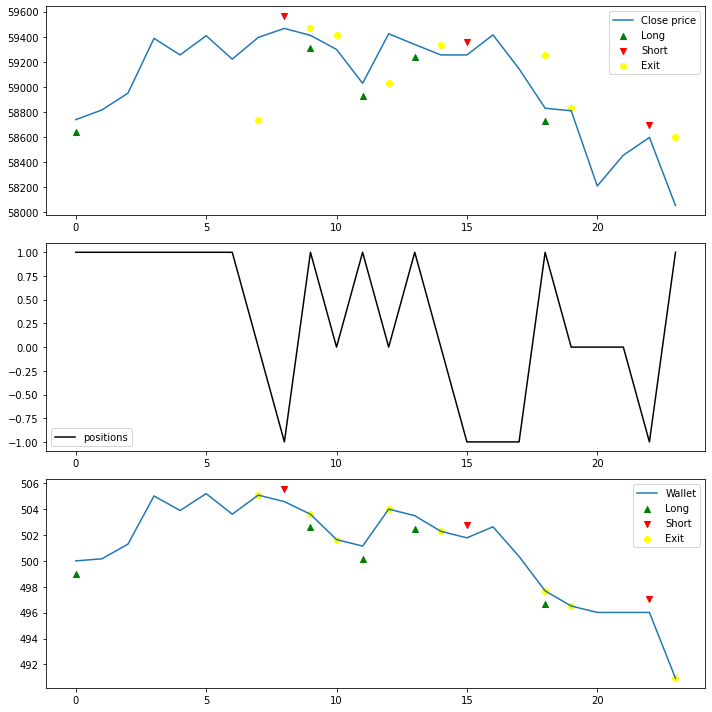

In [341]:
strat.visualize()

### 3. Test performance startegy

In [342]:
SharpeRatio = SharpeRatio(profit)
MaxDrawback = MaxDrawback(profit)
WinLossRatio = WinLossRatio(profit)
CumulativeProfit = CumulativeProfit(profit)
MeanProfit = MeanProfit(profit)

In [343]:
models = ['Logistic Regression']
metrics = ['SharpeRatio', 'MaxDrawback', 'WinLossRatio', 'CumulativeProfit', 'MeanProfit']
metric_data = [[SharpeRatio, MaxDrawback, WinLossRatio, CumulativeProfit, MeanProfit]]

pd.DataFrame(metric_data, index=models, columns=metrics)

,SharpeRatio,MaxDrawback,WinLossRatio,CumulativeProfit,MeanProfit
Logistic Regression,0.213375,-3.717138,2.0,9.068137,0.377839
